Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

# Exploring time step limiters for P3M: tuning $\eta$

## Set up the environment and parameters

In [1]:
# pyright: reportWildcardImportFromLibrary=false
from wip3m import *

In [2]:
workdir = ROOT_PATH + "results/"
output_path = OUTPUT_PATH

# STANDARD PARAMETERS:
L = 32  # Box size in Mpc/h
N = 32  # Density grid size
Np = 32  # Number of dark matter particles per spatial dimension
Npm = 64  # PM grid size
n_Tiles = 8  # Make sure Npm/n_Tiles >= 6
    
force = force_hard = True
run_id = "notebook11"

TimeStepDistribution = 0  # 0: constant, 1: log, 2: exp, 3: custom
nsteps = 50  # not used for TimeStepDistribution=3

In [3]:
# Automatic reloading of modules
%load_ext autoreload
%autoreload 2

from os.path import isfile
from pathlib import Path
import numpy as np

from pysbmy.power import PowerSpectrum
from pysbmy.field import read_field
from pysbmy.timestepping import StandardTimeStepping, P3MTimeStepping

from wip3m.tools import get_k_max, generate_sim_params, generate_white_noise_Field, run_simulation
from wip3m.params import params_CONCEPT_kmax_missing, cosmo_small_to_full_dict, z2a, BASELINE_SEEDPHASE
from wip3m.plot_utils import *  # type: ignore

In [4]:
corner = 0.0
RedshiftLPT = 19.0
RedshiftFCs = 0.0

ai = z2a(RedshiftLPT)
af = z2a(RedshiftFCs)
k_max = get_k_max(L, N)  # k_max in h/Mpc
print(f"k_max = {k_max}")
# cosmo = params_planck_kmax_missing.copy()
cosmo = params_CONCEPT_kmax_missing.copy()
cosmo["k_max"] = k_max

wd = workdir + run_id + "/"
simdir = output_path + run_id + "/"
gravpotdir = simdir + "gravpot/"
momentadir = simdir + "p_res/"
logdir = simdir + "logs/"
if force_hard:
    import shutil
    if Path(simdir).exists():
        shutil.rmtree(simdir)
    if Path(wd).exists():
        shutil.rmtree(wd)
Path(wd).mkdir(parents=True, exist_ok=True)
Path(gravpotdir).mkdir(parents=True, exist_ok=True)
Path(momentadir).mkdir(parents=True, exist_ok=True)
Path(logdir).mkdir(parents=True, exist_ok=True)

input_white_noise_file = simdir + "input_white_noise.h5"
input_seed_phase_file = simdir + "seed"
ICs_path = simdir + "initial_density.h5"
simpath = simdir

# Path to the input matter power spectrum (generated later)
input_power_file = simdir + "input_power.h5"

# Paths to the time step logs
OutputTimestepsLog = simdir + "timesteps_log.txt"

# Path to the output gravitational potential field
OutputGravitationalPotentialBase = gravpotdir + "gp"

# Path to the output momenta field
OutputMomentaBase = momentadir + "p"

k_max = 5.442


### Generate the parameter files

In [5]:
common_params = {
    "Np": Np,
    "N": N,
    "L": L,
    "corner0": corner,
    "corner1": corner,
    "corner2": corner,
    "h": cosmo["h"],
    "Omega_m": cosmo["Omega_m"],
    "Omega_b": cosmo["Omega_b"],
    "n_s": cosmo["n_s"],
    "sigma8": cosmo["sigma8"],
}

lpt_params = common_params.copy()
lpt_params["method"] = "lpt"
lpt_params["InputPowerSpectrum"] = input_power_file
lpt_params["ICsMode"] = 1
lpt_params["InputWhiteNoise"] = input_white_noise_file

p3m_params = common_params.copy()
p3m_params["method"] = "p3m"
p3m_params["EvolutionMode"] = 7  # 7: COLA with P3M force evaluation
p3m_params["TimeStepDistribution"] = TimeStepDistribution
p3m_params["nsteps"] = nsteps
p3m_params["ai"] = ai
p3m_params["af"] = af
p3m_params["RedshiftLPT"] = RedshiftLPT
p3m_params["RedshiftFCs"] = RedshiftFCs
p3m_params["Npm"] = Npm
p3m_params["n_Tiles"] = n_Tiles
p3m_params["RunForceDiagnostic"] = False
p3m_params["cosmo_dict"] = cosmo
p3m_params["WriteGravPot"] = True
p3m_params["OutputGravitationalPotentialBase"] = OutputGravitationalPotentialBase
p3m_params["WriteReferenceFrame"] = True
p3m_params["OutputMomentaBase"] = OutputMomentaBase

[10:08:49|INFO      ]|(wip3m.tools) Generating parameter file...
[10:08:49|STATUS    ]|Writing parameter file in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook11/example_lpt.sbmy'...
[10:08:49|STATUS    ]|Writing parameter file in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook11/example_lpt.sbmy' done.
[10:08:49|INFO      ]|(wip3m.tools) Parameter file written to /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook11/example_lpt.sbmy
P3M nsteps = 50:
[10:08:49|INFO      ]|(wip3m.tools) Time-stepping distribution file: /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook11/nsteps50_ts_p3m.h5
[10:08:49|STATUS    ]|Write timestepping configuration in '/Users/hoellinger/Library/CloudStorage/Dr

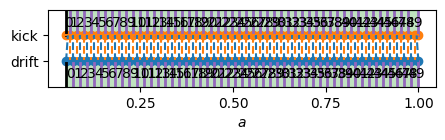

In [6]:
reset_plotting()  # Default style for Simbelmynë
generate_sim_params(lpt_params, ICs_path, wd, simdir, None, force)

print(f"P3M nsteps = {nsteps}:")
file_ext = f"nsteps{nsteps}"  # "p3m" is already in the filename
generate_sim_params(p3m_params, ICs_path, wd, simdir, file_ext, force)
setup_plotting()  # Reset plotting style for this project

In [7]:
TSpath = wd + file_ext + "_ts_p3m.h5" if file_ext else wd + "ts_p3m.h5"
if TimeStepDistribution in [0, 1, 2]:
    TS = StandardTimeStepping.read(TSpath)
    aiDrift = TS.aiDrift
    nsteps = TS.nsteps
elif TimeStepDistribution == 3:
    TS = P3MTimeStepping.read(TSpath)
    aiDrift = TS.aiDrift
    nsteps = TS.nsteps
else:
    raise ValueError(f"Invalid TimeStepDistribution: {TimeStepDistribution}")

[10:08:50|STATUS    ]|Read timestepping configuration in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook11/nsteps50_ts_p3m.h5'...
[10:08:50|STATUS    ]|Read timestepping configuration in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook11/nsteps50_ts_p3m.h5' done.


### Generate the initial phase

In [8]:
generate_white_noise_Field(
    L=L,
    size=N,
    corner=corner,
    seedphase=BASELINE_SEEDPHASE,
    fname_whitenoise=input_white_noise_file,
    seedname_whitenoise=input_seed_phase_file,
    force_phase=force,
)

### Generating the input power spectrum

In [9]:
# If cosmo["WhichSpectrum"] == "class", then classy is required.
if not isfile(input_power_file) or force:
    Pk = PowerSpectrum(L, L, L, N, N, N, cosmo_small_to_full_dict(cosmo))
    Pk.write(input_power_file)

[10:08:50|STATUS    ]|Setting up Fourier grid...
[10:08:50|STATUS    ]|Setting up Fourier grid done.
[10:08:50|STATUS    ][10:08:50|STATUS    ]|Write power spectrum in data file '/Users/hoellinger/WIP3M/notebook11/input_power.h5'...
|Computing normalization of the power spectrum...
[10:08:50|STATUS    ]|Computing normalization of the power spectrum done.
[10:08:50|STATUS    ]|Computing power spectrum...
[10:08:50|STATUS    ]|Computing power spectrum done.
[10:08:50|DIAGNOSTIC]==|L0=32, L1=32, L2=32
[10:08:50|DIAGNOSTIC]==|N0=32, N1=32, N2=32, N2_HC=17, N_HC=17408, NUM_MODES=464
[10:08:50|STATUS    ]|Write power spectrum in data file '/Users/hoellinger/WIP3M/notebook11/input_power.h5' done.


## Running the simulations

In [10]:
run_simulation("lpt", lpt_params, wd, logdir)

[10:08:50|COMMAND   ]|simbelmyne /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook11/example_lpt.sbmy /Users/hoellinger/WIP3M/notebook11/logs/lpt.txt
[10:08:50|INFO      ]|
[10:08:50|INFO      ]|            .-~~-.--.
[10:08:50|INFO      ]|           :         )
[10:08:50|INFO      ]|     .~ ~ -.\       /.- ~~ .
[10:08:50|INFO      ]|     >       `.   .'       <
[10:08:50|INFO      ]|    (         .- -.         )
[10:08:50|INFO      ]|     `- -.-~  `- -'  ~-.- -'
[10:08:50|INFO      ]|       (        :        )           _ _ .-:        ___________________________________
[10:08:50|INFO      ]|        ~--.    :    .--~        .-~  .-~  }                    SIMBELMYNË
[10:08:50|INFO      ]|            ~-.-^-.-~ \_      .~  .-~   .~           (c) Florent Leclercq 2012 - SBMY_YEAR 
[10:08:50|INFO      ]|                     \ '     \ '_ _ -~              ___________________________________
[10:08:50|INFO      ]|     

In [11]:
file_ext = f"nsteps{nsteps}"
if not isfile(simdir + f"{file_ext}_final_density_p3m.h5") or force:
    !simbelmyne {wd}{file_ext}_example_p3m.sbmy {logdir}{file_ext}_p3m.txt

[10:08:51|COMMAND   ]|/Users/hoellinger/miniforge3/envs/p3m/bin/simbelmyne /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook11/nsteps50_example_p3m.sbmy /Users/hoellinger/WIP3M/notebook11/logs/nsteps50_p3m.txt
[10:08:51|INFO      ]|
[10:08:51|INFO      ]|            .-~~-.--.
[10:08:51|INFO      ]|           :         )
[10:08:51|INFO      ]|     .~ ~ -.\       /.- ~~ .
[10:08:51|INFO      ]|     >       `.   .'       <
[10:08:51|INFO      ]|    (         .- -.         )
[10:08:51|INFO      ]|     `- -.-~  `- -'  ~-.- -'
[10:08:51|INFO      ]|       (        :        )           _ _ .-:        ___________________________________
[10:08:51|INFO      ]|        ~--.    :    .--~        .-~  .-~  }                    SIMBELMYNË
[10:08:51|INFO      ]|            ~-.-^-.-~ \_      .~  .-~   .~           (c) Florent Leclercq 2012 - SBMY_YEAR 
[10:08:51|INFO      ]|                     \ '     \ '_ _ -~              ___

## Gravitational potential

In [14]:
slice_ijk = (N // 2, slice(None), slice(None))
steps = [1,25,50]  # Steps to compare
DELTA_P3M = read_field(simdir + f"nsteps{nsteps}_final_density_p3m.h5").data[slice_ijk]
DELTA_GP1 = read_field(gravpotdir + f"gp_nforce{steps[0]}.h5").data[slice_ijk]
DELTA_GP2 = read_field(gravpotdir + f"gp_nforce{steps[1]}.h5").data[slice_ijk]
DELTA_GP3 = read_field(gravpotdir + f"gp_nforce{steps[2]}.h5").data[slice_ijk]
diff_gp2_gp1 = DELTA_GP3 - DELTA_GP1
diff_gp3_gp1 = DELTA_GP3 - DELTA_GP2

[10:11:14|STATUS    ]====|Read field in data file '/Users/hoellinger/WIP3M/notebook11/nsteps50_final_density_p3m.h5'...
[10:11:14|DIAGNOSTIC]======|ranges=[np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.int32(32), np.int32(32), np.int32(32)]
[10:11:14|STATUS    ]====|Read field in data file '/Users/hoellinger/WIP3M/notebook11/nsteps50_final_density_p3m.h5' done.
[10:11:14|STATUS    ]====|Read field in data file '/Users/hoellinger/WIP3M/notebook11/gravpot/gp_nforce1.h5'...
[10:11:14|DIAGNOSTIC]======|ranges=[np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.int32(32), np.int32(32), np.int32(32)]
[10:11:14|STATUS    ]====|Read field in data file '/Users/hoellinger/WIP3M/notebook11/gravpot/gp_nforce1.h5' done.
[10:11:14|STATUS    ]====|Read field in data file '/Users/hoellinger/WIP3M/notebook11/gravpot/gp_nforce25.h5'...
[10:11:14|DIAGNOSTIC]======|ranges=[np.float64(0.0)

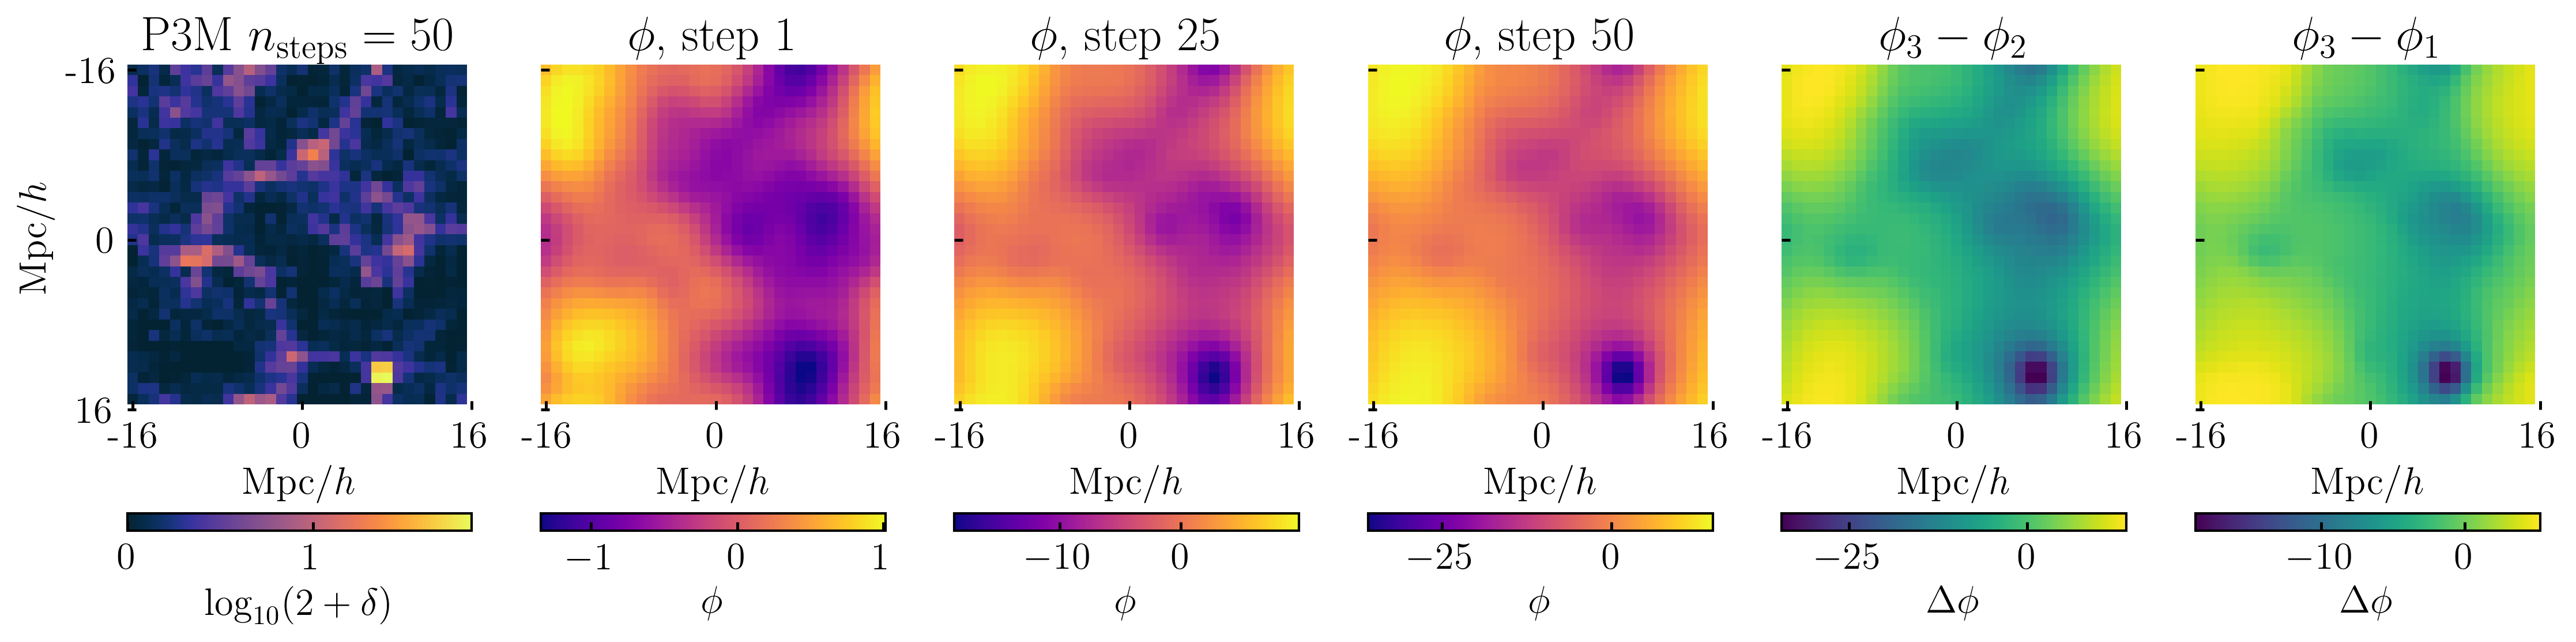

In [15]:
fields = ["p3m", "gp1", "gp2", "gp3", "diff_gp2_gp1", "diff_gp3_gp1"]  # fields to plot

figname = "_".join(fields)
slices_dict = {
    "p3m": DELTA_P3M,
    "gp1": DELTA_GP1,
    "gp2": DELTA_GP2,
    "gp3": DELTA_GP3,
    "diff_gp2_gp1": diff_gp2_gp1,
    "diff_gp3_gp1": diff_gp3_gp1,
}
titles_dict = {
    "p3m": f"P3M $n_\\mathrm{{steps}}={nsteps}$",
    "gp1": rf"$\phi$, step {steps[0]}",
    "gp2": rf"$\phi$, step {steps[1]}",
    "gp3": rf"$\phi$, step {steps[2]}",
    "diff_gp2_gp1": r"$\phi_3 - \phi_2$",
    "diff_gp3_gp1": r"$\phi_3 - \phi_1$",
}

npanels = len(fields)
fig, axs = plt.subplots(1, npanels, figsize=(3 * npanels, 4), sharey=True)

ims = []
for i, key in enumerate(fields):
    ax = axs[i]
    data = slices_dict[key]
    title = titles_dict[key]

    if key.startswith("diff"):
        im = ax.imshow(data, cmap="viridis")
    elif key.startswith("gp"):
        im = ax.imshow(data, cmap="plasma")
        # im = ax.imshow(np.log10(1 + data - np.min(data)), cmap="plasma")
    else:
        im = ax.imshow(np.log10(2 + data), cmap=cmap)

    ims.append((im, key))
    ax.set_title(title, fontsize=fs_titles)
    for spine in ax.spines.values():
        spine.set_visible(False)

axs[0].set_yticks([0, N // 2, N])
axs[0].set_yticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
axs[0].set_ylabel(r"Mpc/$h$", size=GLOBAL_FS_SMALL)

for i, ax in enumerate(axs):
    ax.set_xticks([0, N // 2, N])
    ax.set_xticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
    ax.set_xlabel(r"Mpc/$h$", size=GLOBAL_FS_SMALL)

for ax, (im, key) in zip(axs, ims):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    if key.startswith("gp"):
        cb.set_label(r"$\phi$", fontsize=fs)
    elif key.startswith("diff"):
        cb.set_label(r"$\Delta\phi$", fontsize=fs)
    else:
        cb.set_label(r"$\log_{10}(2 + \delta)$", fontsize=fs)
    cb.ax.tick_params(labelsize=fs)
    cax.xaxis.set_ticks_position("bottom")
    cax.xaxis.set_label_position("bottom")
fig.savefig(
    simdir + f"{figname}.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)
fig.savefig(
    simdir + f"{figname}.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

## Residual momenta

In [17]:
component = 0
slice_cijk = (component, N // 2, slice(None), slice(None))
steps = [0,24,49]  # Steps to compare
DELTA_P1 = read_field(momentadir + f"p{steps[0]}.h5").data[slice_cijk]
DELTA_P2 = read_field(momentadir + f"p{steps[1]}.h5").data[slice_cijk]
DELTA_P3 = read_field(momentadir + f"p{steps[2]}.h5").data[slice_cijk]

[10:11:29|STATUS    ]======|Read field in data file '/Users/hoellinger/WIP3M/notebook11/p_res/p0.h5'...
[10:11:29|DIAGNOSTIC]========|ranges=[np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.int32(32), np.int32(32), np.int32(32)]
[10:11:29|STATUS    ]======|Read field in data file '/Users/hoellinger/WIP3M/notebook11/p_res/p0.h5' done.
[10:11:29|STATUS    ]======|Read field in data file '/Users/hoellinger/WIP3M/notebook11/p_res/p24.h5'...
[10:11:29|DIAGNOSTIC]========|ranges=[np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.int32(32), np.int32(32), np.int32(32)]
[10:11:29|STATUS    ]======|Read field in data file '/Users/hoellinger/WIP3M/notebook11/p_res/p24.h5' done.
[10:11:29|STATUS    ]======|Read field in data file '/Users/hoellinger/WIP3M/notebook11/p_res/p49.h5'...
[10:11:29|DIAGNOSTIC]========|ranges=[np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(

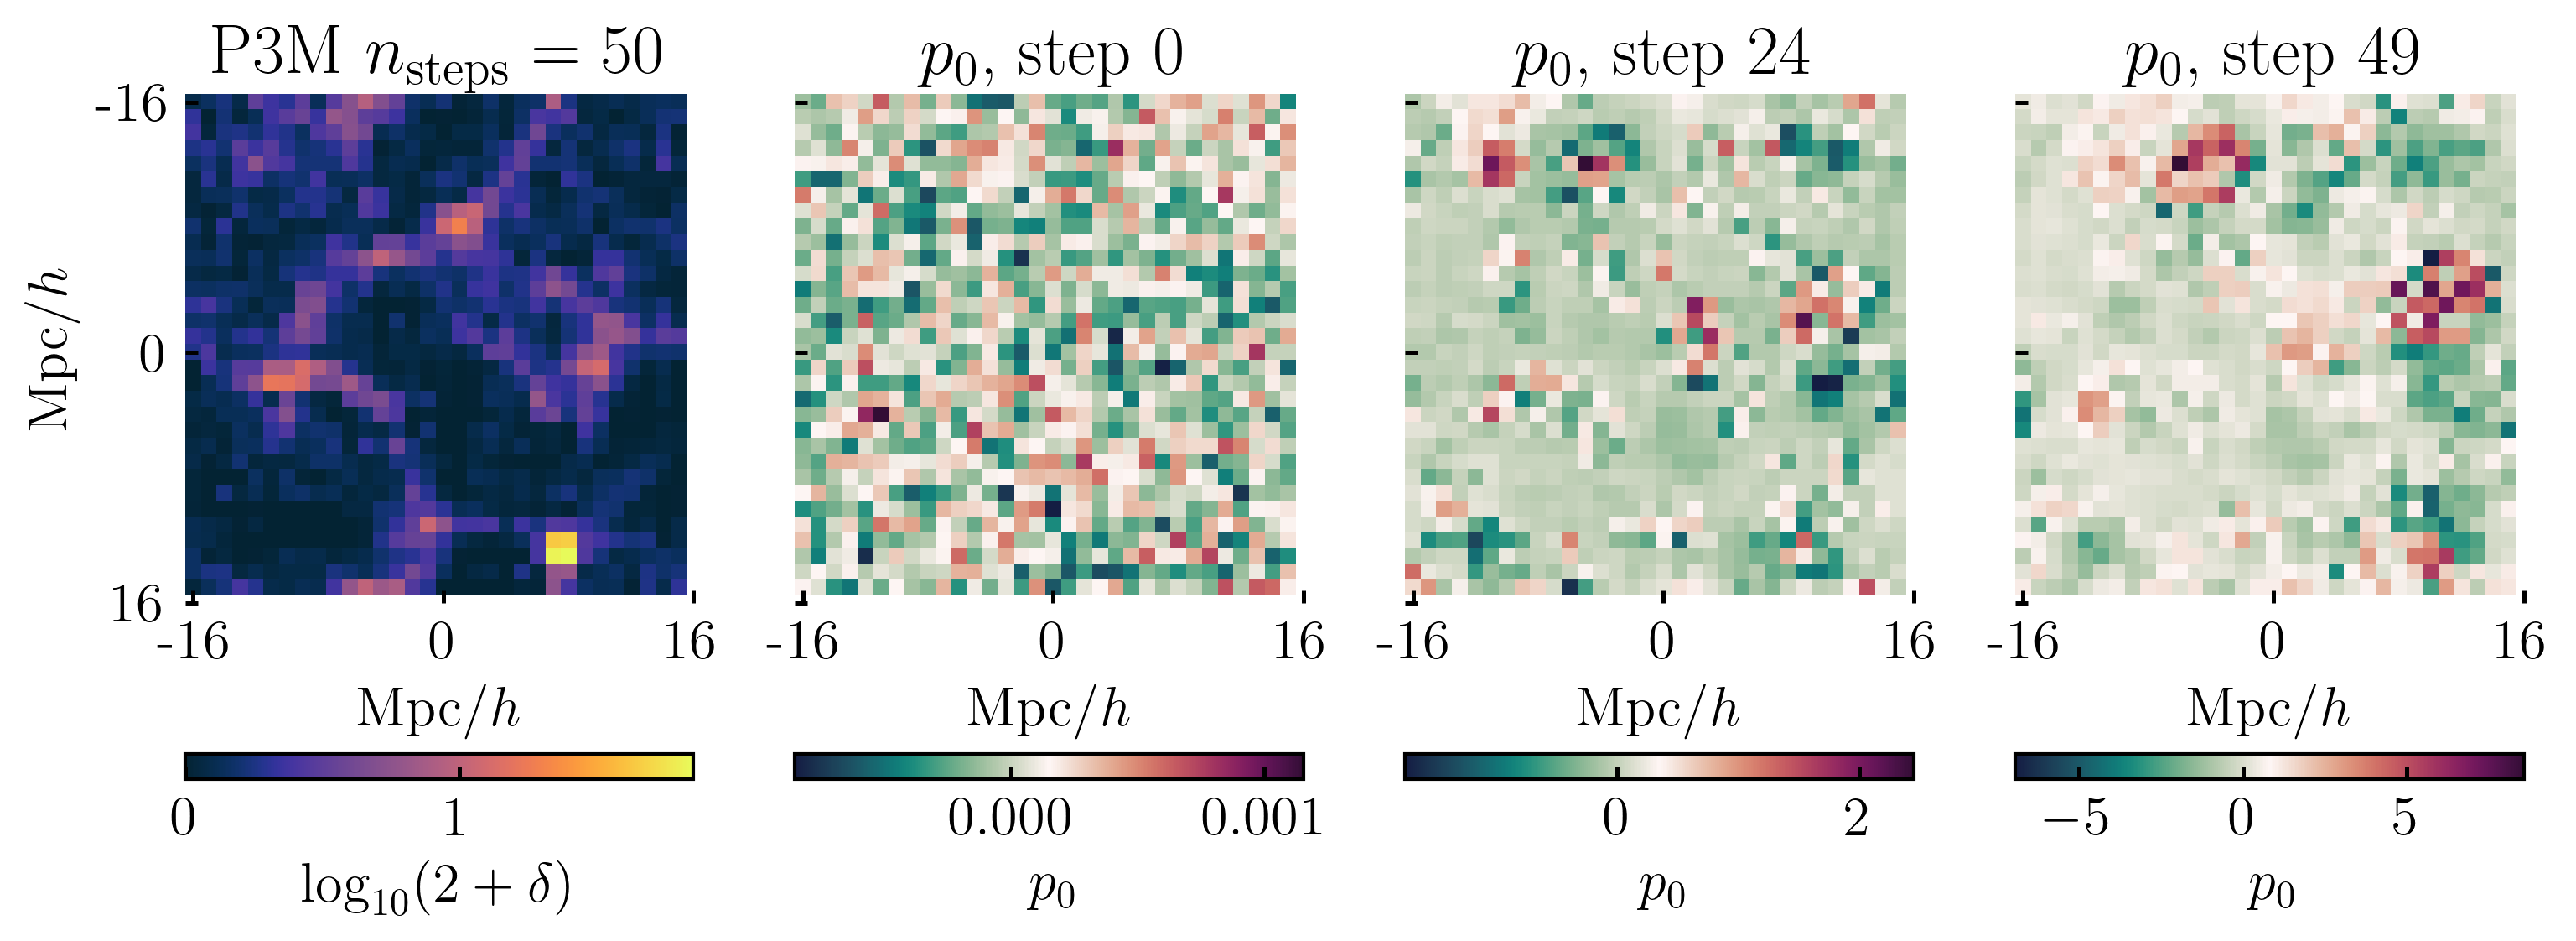

In [18]:
fields = ["p3m", "p1", "p2", "p3"]
figname = "_".join(fields)
slices_dict = {
    "p3m": DELTA_P3M,
    "p1": DELTA_P1,
    "p2": DELTA_P2,
    "p3": DELTA_P3,
}
titles_dict = {
    "p3m": f"P3M $n_\\mathrm{{steps}}={nsteps}$",
    "p1": rf"$p_{component}$, step {steps[0]}",
    "p2": rf"$p_{component}$, step {steps[1]}",
    "p3": rf"$p_{component}$, step {steps[2]}",
}

npanels = len(fields)
fig, axs = plt.subplots(1, npanels, figsize=(3 * npanels, 4), sharey=True)

ims = []
for i, key in enumerate(fields):
    ax = axs[i]
    data = slices_dict[key]
    title = titles_dict[key]

    if key.startswith("diff"):
        im = ax.imshow(data, cmap=cm.balance)
    elif key.startswith("p3m"):
        im = ax.imshow(np.log10(2 + data), cmap=cmap)
    else:
        im = ax.imshow(data, cmap=cm.curl)

    ims.append((im, key))
    ax.set_title(title, fontsize=fs_titles)
    for spine in ax.spines.values():
        spine.set_visible(False)

axs[0].set_yticks([0, N // 2, N])
axs[0].set_yticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
axs[0].set_ylabel(r"Mpc/$h$", size=GLOBAL_FS_SMALL)

for i, ax in enumerate(axs):
    ax.set_xticks([0, N // 2, N])
    ax.set_xticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
    ax.set_xlabel(r"Mpc/$h$", size=GLOBAL_FS_SMALL)

for ax, (im, key) in zip(axs, ims):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    if key.startswith("p3m"):
        cb.set_label(r"$\log_{10}(2 + \delta)$", fontsize=fs)
    elif key.startswith("diff"):
        cb.set_label(r"$\Delta\phi$", fontsize=fs)
    else:
        cb.set_label(rf"$p_{component}$", fontsize=fs)
    cb.ax.tick_params(labelsize=fs)
    cax.xaxis.set_ticks_position("bottom")
    cax.xaxis.set_label_position("bottom")
fig.savefig(
    simdir + f"{figname}.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)
fig.savefig(
    simdir + f"{figname}.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()